# Simple Backtest Example - SPO

## 1. Setup

#### 1.1 Load InvestOS module

In [1]:
# Add relative path to module lookup path...
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

# ... then import module
import investos as inv

# Import other required modules
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.plotting.backend = "plotly"
import numpy as np

#### 1.2 Load historical stock prices and volumes

Place in examples/data directory [data from Kaggle](https://www.kaggle.com/datasets/camnugent/sandp500/download?datasetVersionNumber=4)

Note: you will need to create (and sign into) a free Kaggle account

In [2]:
# A. Load S&P 500 tickers, names, and industries
dir_name = './data/'

df = pd.read_csv(
    dir_name + 'all_stocks_5yr.csv'
).rename(columns={'Name': 'asset'})

In [3]:
# B. Keep date, price (mid-way between bid and ask), and volume only
df = df[['asset', 'date', 'open', 'volume']]
df = df.rename(columns={'open': 'price'})

#### 1.3 Create (fake) historical stock bid/ask spreads

In [4]:
# Note: real data should be used for this, wherever possible
# For now, assume 0.01% (i.e. 1 cent on $100.00 stock)
df['spread'] = 1/10_000 # EXPECTED AS A PERCENT

#### 1.4 Clean DF

In [5]:
# Keep stocks (assets) with less than 10 price nulls only
df = df.groupby('asset').filter(lambda g: g['price'].isnull().sum().sum() < 10)
# Make date type datetime
df['date'] = pd.to_datetime(df['date'])

#### 1.5 Calculate returns

In [6]:
df['price_t+1'] = df.groupby(['asset'])['price'].shift(-1)

In [7]:
df['return'] = df['price'] / df['price_t+1'] - 1 # fwd looking return

In [8]:
# Keep required columns only
df = df[['asset', 'date', 'price', 'return', 'volume', 'spread']]

# Drop null returns
df = df[df['return'].notnull()]

In [9]:
# Drop where return data insufficient
UNIQUE_RETURNS_P_THRESHOLD = 0.99

s_nunique = df.groupby(['asset']).nunique()['return']
max_unique_returns = s_nunique.max()
df_percent_returns_unique = (s_nunique / max_unique_returns).reset_index()
df_percent_returns_unique = df_percent_returns_unique.rename(columns={'return': 'p_unique'})
df = df.merge(df_percent_returns_unique, on=['asset'], how='left')
df = df[df['p_unique'] >= UNIQUE_RETURNS_P_THRESHOLD]
df = df.drop(columns=['p_unique'])

#### 1.6 Split dfs into historical and forecast

In [10]:
date_split_forecasts = '2016-01-01'

df_forecast = df[df.date >= date_split_forecasts][['asset', 'date', 'return']]
df_actual = df

#### 1.7 Create (fake) forecasts

In [11]:
np.random.seed(0)

# Median (daily) return is VERY close to 0:
print("Median return:", df_forecast['return'].median())

# Cap returns at +- 10%...
df_forecast['return'] = df_forecast['return'].clip(-0.1, 0.1)

# ... then reduce signal...
df_forecast['return'] /= 10

# ... then add guassian noise to daily returns
std = df_actual[df_actual.date >= date_split_forecasts]['return'].var() ** 0.5
noise = np.random.normal(0, std, size=df_forecast.shape[0])

df_forecast['return'] = df_forecast['return'] + noise

Median return: -0.0008741769337591299


In [12]:
# Make sure predictions aren't too accurate:

agree_on_sign = np.sign(df_forecast['return']) == np.sign(
    df_actual[df_actual.date >= date_split_forecasts]['return']
)

print(
    "Return predictions have the right sign %.1f%% of the time" %
    ((agree_on_sign.sum() / agree_on_sign.shape[0]) * 100)
)

Return predictions have the right sign 52.3% of the time


## 2. Portfolio optimization

#### 2.1 Create portfolio optimization instance

In [13]:
from investos.portfolio_optimization.cost_model import *
from investos.portfolio_optimization.constraint_model import *
from investos.portfolio_optimization.risk_model import *

In [22]:
strategy = inv.portfolio_optimization.strategy.SPO(
    costs = [
        TradingCost() * 10,
        HoldingCost(),
    ],
    constraints = [
        MaxLeverageConstraint(limit=3.0),
        MinWeightConstraint(), 
        MaxWeightConstraint(), 
        EqualLongShortConstraint() 
    ],
)

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
    aum=300_000_000,
)

In [23]:
report = backtest.optimize()

Optimizing...
Done simulating.


#### 2.2 Backtest results

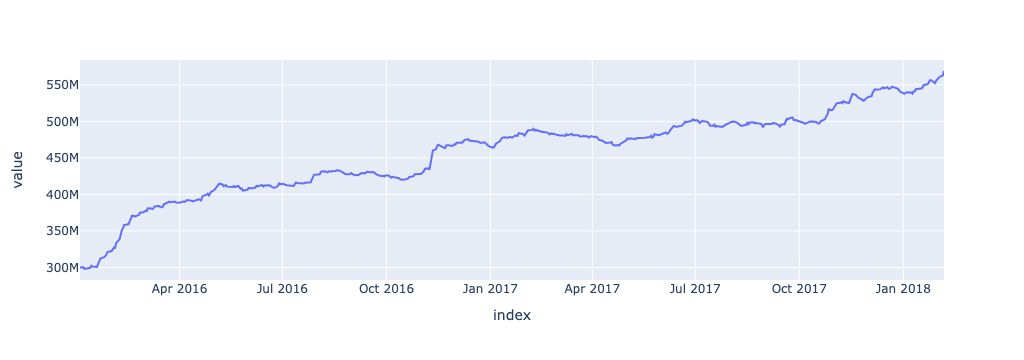

In [24]:
fig = report.v.plot()
fig.layout.update(showlegend=False)
fig.show()

In [25]:
report.summary

Number of periods                                  528
Initial timestamp                  2016-01-04 00:00:00
Final timestamp                    2018-02-06 00:00:00
Annualized portfolio return (%)                 35.77%
Sharpe ratio                                     4.463
Max drawdown                                     4.63%
Annual turnover (x)                            693.89x


#### 2.3 Examples

**A) Default options:**

- Long short
- Equal long short
- 2x max leverage (i.e. exposure)
- 100MM AUM
- Default trading and holding cost models
- Default (long and short) position weight constraints [2.5%]

```python
# Code:

strategy = inv.portfolio_optimization.strategy.SPO()

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
)
```

**B) Same as A, but 200MM AUM:**

```python
# Code:

strategy = inv.portfolio_optimization.strategy.SPO()

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
    aum=200_000_000,
)
```

**C) Same as B, but half price movement on trading:**

```python
# Code:

strategy = inv.portfolio_optimization.strategy.SPO(
    costs = [
        TradingCost(price_movement_sensitivity=0.5), 
        HoldingCost(),
    ],
)

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
    aum=200_000_000,
)
```

**D) Same as A, but long only (with no leverage):**

```python
# Code:

strategy = inv.portfolio_optimization.strategy.SPO(
    constraints = [
        LongOnlyConstraint(),
        MaxWeightConstraint(), 
    ],
)

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
)
```

**E) Same as A, but 1x leverage:**

```python
# Code:

strategy = inv.portfolio_optimization.strategy.SPO(
    constraints = [
        MaxLeverageConstraint(limit=1.0),
        MinWeightConstraint(), 
        MaxWeightConstraint(), 
        EqualLongShortConstraint() 
    ],
)

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
)
```

**F) Same as A, but discourage costly trades by 10x:**

```python
# Code:

strategy = inv.portfolio_optimization.strategy.SPO(
    costs = [
        TradingCost() * 10, 
        HoldingCost(),
    ],
)

backtest = inv.portfolio_optimization.Backtester(
    df_forecast,
    df_actual,
    strategy=strategy,
    start_date='2016-07-01',
    end_date='2018-01-01',
)
```